## This script creates numerous folders (corresponding to a specific model architecture) in the specified pathway. Various model architectures are trained and the best model (.h5 file) and the loss curves (.png) are saved in the respective folder to be used later for signature development and further analyses.

### This version runs many model architectures (different nodes and lookback values from a single hidden layer model)

**notes:** 
1.   The data is stored in .csv files: PareticvsNonP_RNNData.csv, Speedlabels.csv, Subjectlabels.csv, Phaselabels.csv
2.   A simple LSTM model is run on the data for each model architecture. 




**Created by**: Taniel Winner & Patrick Ihejirika

**Date**: 07/*18*/22

**Step 0**: Mount (connect to) your google drive folder where you want to save the simulation results and model parameters.


In [25]:
# check python version 
from platform import python_version

print(python_version())

3.9.12


In [26]:
# check tensorflow version
import tensorflow as tf

print(tf.__version__)

2.8.2


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [27]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [28]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  9 14:15:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   57C    P8    37W / 320W |    587MiB / 10240MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 44%   

**Step 1**: Import necessary packages to develop model

In [29]:
%pip install matplotlib==3.3.4

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
import math
import keras as k
import pandas as pd
import numpy as np
from copy import copy
import scipy.io
from sklearn.decomposition import PCA
import tensorflow as tf

from scipy.signal import find_peaks
from scipy import interpolate
from numpy import sin,cos,pi,array,linspace,cumsum,asarray,dot,ones
from pylab import plot, legend, axis, show, randint, randn, std,lstsq

from sklearn.manifold import MDS
import csv
import os
from tqdm import tqdm 

Note: you may need to restart the kernel to use updated packages.


**Step 2**: Load in data and specify variables/parameters 

In [30]:
path = '/home/victorphilippecodex/Documents/Hand_Signature/WholeGroup1'

# Non-changing variables 

# number of trials in dataset 
trialnum = 252 # 72 total trials

# number of samples in each trial
trialsamp = 2100

# number of features collected per trial
feats = 15

#Batch size - same as the number of traintrials
batch_size = trialnum

# Number of Layers
numlayers = 1

# Choose the number of iterations to train the model- if this script has been run previously enter a value greater than was 
# inputted before and rerun the script. 
finalepoch = 10000

# load the input data/kinematics
datafilepath = '/home/victorphilippecodex/Documents/Hand_Signature/WholeGroup1/DownsampledGroup1.csv' #input data
all_csvnp = np.loadtxt(datafilepath,delimiter=',').T

# reshape all the input data into a tensor
all_inputdata_s = all_csvnp.reshape(trialnum,trialsamp,feats) 
csvnp = all_inputdata_s
print('original input data shape is: '+ str(all_csvnp.shape ))
print('input data reshaped is: '+ str(all_inputdata_s.shape))

original input data shape is: (15, 529200)
input data reshaped is: (252, 2100, 15)


**Step 4**: Develop list of model architectures and corresponding variables to train. This step also generates list of folder names and pathways where the models will be saved and accessed later. 

In [31]:
# generate a list of models and corresponding parameters to test 

test_model_nodes = [256] 
seqs = [699] #lookback parameter

# run multiple model architechtures many times to test stability of cost function outputs
runs = 1 # stability analysis - repeat each model architecture this many times
test_model_seq = np.repeat(seqs, runs)

count = np.arange(runs)

All_nodes = np.empty([0,1], dtype='int')
All_seq = np.empty([0,1],dtype='int')
All_valseg = np.empty([0,1],dtype='int')
All_trainseg = np.empty([0,1],dtype='int')
All_modelname = []
All_mod_name = []
count = np.empty([0,1],dtype='int'); #initialize model run -- this serves as the model run ID number
ct = 0
for a in test_model_nodes:
  for b in test_model_seq:
    count = np.append(count,  ct + 1 )
    #if statement for valseg, trainseg based on sequence length
    if int(b) == 699:
      trainseg = 2
      valseg = 1
    

    All_nodes = np.append(All_nodes, a) 
    All_seq = np.append(All_seq, int(b))
    All_valseg = np.append(All_valseg, valseg)
    All_trainseg = np.append(All_trainseg, trainseg)
    All_modelname = np.append(All_modelname, 'UNIT_' + str(a) + '_LB_' + str(b) + '_run_' + str(count[-1]) + '/' )
    All_mod_name = np.append(All_mod_name, 'UNIT_' + str(a) + '_LB_' + str(b) + '_run_' + str(count[-1]) )

    if ct+1 < runs:
      ct += 1
    else:
      ct = 0

print(All_mod_name)

['UNIT_256_LB_699_run_1']


**Step 5**: Train model architectures and save in a loop.

Working on: UNIT_256_LB_699_run_1 model 0 / 1
Epoch 1/10000
2/2 [==============================] - 6s 3s/step - loss: 3.4180 - accuracy: 0.0370 - val_loss: 2.2859 - val_accuracy: 0.0397
Epoch 2/10000
2/2 [==============================] - 5s 3s/step - loss: 1.9858 - accuracy: 0.0408 - val_loss: 1.2882 - val_accuracy: 0.0452
Epoch 3/10000
2/2 [==============================] - 5s 3s/step - loss: 1.1039 - accuracy: 0.0430 - val_loss: 0.7101 - val_accuracy: 0.0410
Epoch 4/10000
2/2 [==============================] - 5s 3s/step - loss: 0.6138 - accuracy: 0.0392 - val_loss: 0.4389 - val_accuracy: 0.0415
Epoch 5/10000
2/2 [==============================] - 5s 3s/step - loss: 0.3971 - accuracy: 0.0423 - val_loss: 0.3207 - val_accuracy: 0.0354
Epoch 6/10000
2/2 [==============================] - 5s 3s/step - loss: 0.2933 - accuracy: 0.0360 - val_loss: 0.2300 - val_accuracy: 0.0395
Epoch 7/10000
2/2 [==============================] - 5s 3s/step - loss: 0.2071 - accuracy: 0.0504 - val_loss: 0.15

/tmp/ipykernel_8391/1672775888.py:71: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=10) #scale the y axis - base 10


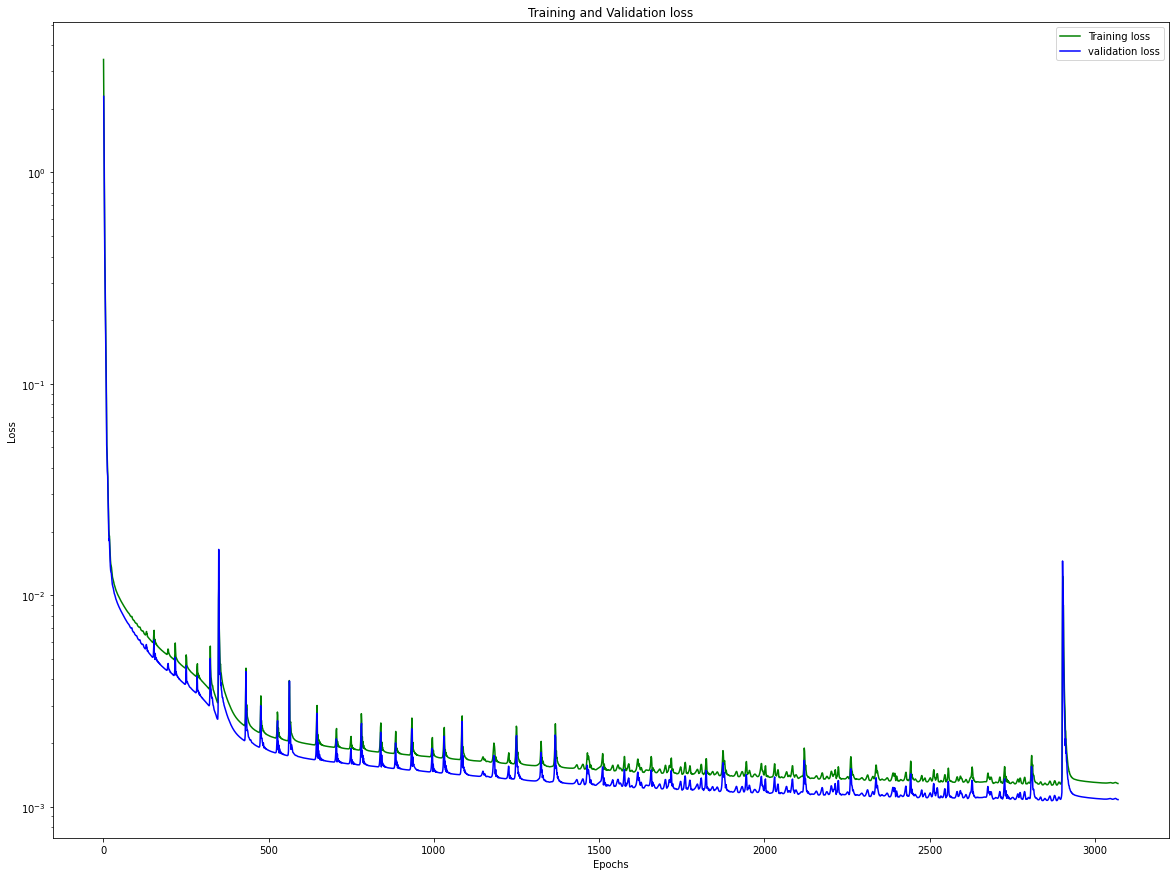

<Figure size 432x288 with 0 Axes>

In [33]:
for j in range(len(All_mod_name)):
    # make folder to store model
    newfoldpath = path + All_mod_name[j]
    try:
      if not os.path.exists(os.path.dirname(newfoldpath)):
          os.makedirs(os.path.dirname(newfoldpath))
    except OSError as err:
          print(err)

    # extract path to store each model and generated data
    savepath = path + All_modelname[j]
    mod_name = All_mod_name[j]

    print('Working on: ' + mod_name + ' model ' + str(j) + ' / ' + str(len(All_mod_name)))
    
    # Specify variables for model run instance

    # Number of Units
    numunits = All_nodes[j]

    # Lookback parameter
    # A number is chosen called the look back parameter where training occurs for this many timesteps and then the units' weights are 
    #reset to zero. Within the look back parameter # of time steps the outputs are predicted, errors calculated, gradient attained which is multiplied by 
    #back propagation to update the weights.  If you add 1 to the lookback parameter- this number should be divisible by the trialsamp- this allows for
    # generating the input and the output data within each dataset- example if triallength is 30, the lookback parameter could be 9
    # so input1 = 1:9, output1 = 2:10.....input3= 21:29, output3= 22:30.Thus there are 3 times we can evaluate error within the trial (resetting paramters each time) 
    lookback = All_seq[j]

    # Training and Validation Set-up
    # Based on the length of the trials and the lookback parameter you can set how much data would be for training vs testing. 
    # For example, if the num = lookback+1 can be divided into the trial length 6 times,  
    # trainseg can be 4 corresponding to the 1st 4 segments and valseg can be 2 corresponding to last 2 segments of trial for validation
    # Select the 1st X segments to be training
    trainseg = All_trainseg[j]
    # Select the last Y segments to be validation
    valseg = All_valseg[j]

    trainx = np.concatenate([csvnp[:,i*lookback:(i+1)*lookback,:] for i in range(trainseg)], axis=0)
    trainy = np.concatenate([csvnp[:,i*lookback+1:(i+1)*lookback+1,:] for i in range(trainseg)], axis=0)

    valindex = (lookback+1)*trainseg
    valx = np.concatenate([csvnp[:,valindex+i*lookback:valindex+(i+1)*lookback,:] for i in range(valseg)], axis=0)
    valy = np.concatenate([csvnp[:,valindex+1+i*lookback:valindex+1+(i+1)*lookback,:] for i in range(valseg)], axis=0)

    # Develop LSTM model
    with tf.device('/device:GPU:1'):

        model=k.models.Sequential()
        model.add(tf.compat.v1.keras.layers.LSTM(units = numunits, stateful=True, return_sequences=True, batch_input_shape =(batch_size,lookback,feats)))
        model.add(tf.compat.v1.keras.layers.Dense(units=feats))

        # compile model
        model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

        # train the model using training and validation
        checkpoint_cb = k.callbacks.ModelCheckpoint(savepath + mod_name + '_bestwhole.h5',save_best_only = True)
        early_stopping_cb = k.callbacks.EarlyStopping(patience = 200,restore_best_weights = True)
        history = model.fit(trainx,trainy,batch_size=trialnum,epochs=finalepoch, validation_data=(valx,valy),shuffle=False, verbose=1,callbacks= [checkpoint_cb,early_stopping_cb])

        # Save history
        np.save(savepath +  mod_name + '_history_loss.npy', history.history['loss'])
        np.save(savepath +  mod_name + '_history_val_loss.npy', history.history['val_loss'])

        fig = plt.figure(figsize=(20,15))
        loss_train = history.history['loss']
        loss_val = history.history['val_loss']
        epochs = np.array(range(1,len(loss_train)+1))
        epshift = epochs - 0.5
        plt.plot(epshift,loss_train, 'g', label='Training loss')
        plt.plot(epochs, loss_val, 'b', label='validation loss') # account for shift in Val loss curve
        plt.yscale('log', basey=10) #scale the y axis - base 10
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        plt.savefig(savepath + mod_name + 'Training_vs_Validation.png', dpi = 300)
        plt.close(fig)# close figure in loop

        min_val_loss = np.min(loss_val)
        min_train_loss = np.min(loss_train)

        np.save(savepath +  mod_name + '_MIN_val_loss.npy', min_val_loss)
        np.save(savepath +  mod_name + '_MIN_train_loss.npy', min_train_loss)